# 0 : Environment_Setup

### 0.1 : Load_packages

In [2]:
!pip install urllib2 --user

  ERROR: Could not find a version that satisfies the requirement urllib2 (from versions: none)
ERROR: No matching distribution found for urllib2


In [3]:
!pip install IMDbPY BeautifulSoup4  --user

In [4]:
# general
import boto3
import datetime as dt
import json
import numpy as np
import pandas as pd
import snowflake.connector

from abc import ABCMeta, abstractmethod
from scipy.spatial.distance import squareform
#from scipy.cluster.hierarchy import ward
from scipy.cluster.hierarchy import  linkage
from scipy.cluster.hierarchy import fcluster

### 0.2 : Connection to Snowflake

In [5]:
%%bash

CFFI_VERSION=$(python -m pip list 2>/dev/null | grep cffi | awk '{print $2}')
echo "Current cffi version="$CFFI_VERSION

pip install --upgrade pip

if [[ "$CFFI_VERSION" == "1.10.0" ]]
then
    echo "Uninstalling cffi"
    pip uninstall --yes cffi
fi

yum_log=$(sudo yum history new && sudo yum install -y libffi-devel openssl-devel)
pip_log=$(python -m pip install --upgrade pip snowflake-connector-python tabulate ipywidgets sqlparse textile)
yum_log=$(jupyter nbextension enable --py widgetsnbextension 2> /dev/null)

if [[ "$CFFI_VERSION" == "cffi (1.10.0)" ]]
then 
   echo "Configuration has changed; restart notebook"
fi


Current cffi version=1.12.3
  Using cached https://files.pythonhosted.org/packages/a4/6d/6463d49a933f547439d6b5b98b46af8742cc03ae83543e4d7688c2420f8b/pip-21.3.1-py3-none-any.whl
  Found existing installation: pip 19.2.2
    Uninstalling pip-19.2.2:


ERROR: Could not install packages due to an EnvironmentError: [Errno 13] Permission denied: '/opt/conda/bin/pip'
Consider using the `--user` option or check the permissions.

bash: line 13: sudo: command not found
ERROR: Could not install packages due to an EnvironmentError: [Errno 13] Permission denied: '/opt/conda/bin/pip'
Consider using the `--user` option or check the permissions.



In [6]:
MAX_FETCHED_RESULTSET_SIZE: int = 500


class Credentials(metaclass=ABCMeta):
    pass
    
    
class SSMPSCredentials(Credentials):
    def __init__(self, secretid: str):
        self._secretid = secretid
        self._secrets = {}
        
    def get_keys(self):
        """
        credential fetching 
        """
        _aws_sm_args = {'service_name': 'secretsmanager', 'region_name': 'us-east-1'}
        secrets_client = boto3.client(**_aws_sm_args)
        get_secret_value_response = secrets_client.get_secret_value(SecretId=self._secretid)
        return get_secret_value_response
    
    
class BaseConnector(metaclass=ABCMeta):
    @abstractmethod
    def connect(self):
        raise NotImplementedError
        

class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )

        return ctx


def execute_query(query: str):
    cur = ctx.cursor()
    try:
        cur.execute(query)
        while True:
            results = cur.fetchmany(MAX_FETCHED_RESULTSET_SIZE)
            if len(results) == 0:
                break
            for row in results:
                yield row
    finally:
        cur.close()
         
def execute_insert_query(query: str):
    cur = ctx.cursor()
    try:
        cur.execute(query)
    finally:
        cur.close()

# 1 : Data Load

In [7]:
# Input data from max_dev snowflake
connector = SnowflakeConnector(SSMPSCredentials('datascience-max-dev-sagemaker-notebooks'))
ctx = connector.connect(dbname='MAX_DEV', schema='WORKSPACE')
cur = ctx.cursor()

In [8]:
#long_tail = '_lt'
#overlap_output_date = '0814'#

#if not overlap_output_date:
#    overlap_output_date = dt.date.today().strftime('%m%d')


#overlap_endpoint_table = f'../Audience_Overlap/{overlap_output_date}_audience_overlap_endpoint_table_max_filtered{long_tail}.csv'
#overlap_id_mapping_table = f'../Audience_Overlap/{overlap_output_date}_audience_overlap_id_mapping_table_output_max_filtered{long_tail}.csv'

In [9]:
power_df_str='''
select * from cds_title_power_index_series_level
'''
power_df=pd.DataFrame(cur.execute(power_df_str).fetch_pandas_all())

In [10]:
#input_master = pd.read_csv(overlap_endpoint_table)
#input_index = pd.read_csv(overlap_id_mapping_table)

#querystr_master='''select * from  max_prod.DATASCIENCE.MAX_AUDIENCE_OVERLAP_ENDPOINT where dt = '2022-03-27'
#'''
querystr_master='''select * from  max_prod.DATASCIENCE.MAX_AUDIENCE_OVERLAP_FILTERED_ENDPOINT where dt = '2022-04-10'
'''
input_master=pd.DataFrame(cur.execute(querystr_master).fetch_pandas_all())

querystr_index='''
select * from max_prod.datascience_stage.AUDIENCE_OVERLAP_CONSOLIDATED_IDS 
'''
input_index=pd.DataFrame(cur.execute(querystr_index).fetch_pandas_all())

In [11]:
input_master.head()

,SCORE,INDEX_1,CONSOLIDATED_TITLE_1,LEVEL_1_CATG_NAME_1,CONSOLIDATED_ID_1,INDEX_2,CONSOLIDATED_TITLE_2,LEVEL_1_CATG_NAME_2,CONSOLIDATED_ID_2,DT
0,1.000000,0,euphoria,series,GXKN_xQX5csPDwwEAAABj,0,euphoria,series,GXKN_xQX5csPDwwEAAABj,2022-04-10
1,0.795509,0,euphoria,series,GXKN_xQX5csPDwwEAAABj,1,game of thrones,series,GVU2cggagzYNJjhsJATwo,2022-04-10
2,0.842598,0,euphoria,series,GXKN_xQX5csPDwwEAAABj,2,friends,series,GXdbR_gOXWJuAuwEAACVH,2022-04-10
3,0.666564,0,euphoria,series,GXKN_xQX5csPDwwEAAABj,3,south park,series,GXr7SEgRi2sLCAAEAAAQu,2022-04-10
4,0.206462,0,euphoria,series,GXKN_xQX5csPDwwEAAABj,4,last week tonight with john oliver,series,GVU2cCgUFTYNJjhsJATuH,2022-04-10


In [12]:
input_index=input_master[['INDEX_1','CONSOLIDATED_TITLE_1','LEVEL_1_CATG_NAME_1']].drop_duplicates()

In [13]:
input_index=input_index.rename({'CONSOLIDATED_TITLE_1':'CONSOLIDATED_TITLE','LEVEL_1_CATG_NAME_1':'LEVEL_1_CATG_NAME','INDEX_1':'INDEX'},axis=1)

In [14]:
input_index['CONSOLIDATED_TITLE']=input_index.CONSOLIDATED_TITLE.str.replace('$','')

In [15]:
input_index.head()

,INDEX,CONSOLIDATED_TITLE,LEVEL_1_CATG_NAME
0,0,euphoria,series
22,1,game of thrones,series
1092,2,friends,series
2162,3,south park,series
87,4,last week tonight with john oliver,series


In [16]:
input_index.shape

(1070, 3)

In [17]:
power_df.shape

(4465, 3)

In [18]:
power_df.head()

,INDEX,ACQUIRING_POWER,RETENTION_POWER
0,#GeorgeWashington,0.000540,0.000143
1,*batteries not included,0.000815,0.000381
2,"1, 2, 3 All Eyes on Me",0.001019,0.000303
3,10 Years,0.001776,0.001602
4,10 to Midnight,0.000876,0.000317


In [19]:
power_df['title']=power_df['INDEX'].str.lower()

In [20]:
from sklearn.preprocessing import quantile_transform
quantile_transform(power_df['ACQUIRING_POWER'].values.reshape(-1, 1), n_quantiles=100, random_state=0, copy=True).ravel()

array([0.18326142, 0.32610116, 0.41462098, ..., 0.60940556, 0.27889646,
       0.01792393])

In [21]:
from sklearn.preprocessing import quantile_transform
power_df['ACQUIRING_POWER_std']= quantile_transform(power_df['ACQUIRING_POWER'].values.reshape(-1, 1), n_quantiles=100, random_state=0, copy=True).ravel()
power_df['RETENTION_POWER_std']= quantile_transform(power_df['RETENTION_POWER'].values.reshape(-1, 1), n_quantiles=100, random_state=0, copy=True).ravel()

In [22]:
all_index=input_index.merge(power_df.drop_duplicates(subset = ["title"]),left_on='CONSOLIDATED_TITLE',right_on='title',how='left')

In [23]:
input_index.shape

(1070, 3)

In [24]:
all_index.shape

(1070, 9)

In [25]:
all_index.tail(20)

,INDEX_x,CONSOLIDATED_TITLE,LEVEL_1_CATG_NAME,INDEX_y,ACQUIRING_POWER,RETENTION_POWER,title,ACQUIRING_POWER_std,RETENTION_POWER_std
1050,7022,mrs. doubtfire,other,Mrs. Doubtfire,0.013321,0.006424,mrs. doubtfire,0.903583,0.840627
1051,7047,home alone 2: lost in new york,other,NaN,NaN,NaN,NaN,NaN,NaN
1052,7053,the suicide squad,other,The Suicide Squad,1.637846,0.807640,the suicide squad,0.991099,0.990131
1053,7067,unfriended,other,NaN,NaN,NaN,NaN,NaN,NaN
1054,7075,armageddon,other,NaN,NaN,NaN,NaN,NaN,NaN
1055,7081,a star is born,other,A Star Is Born,0.008911,0.006503,a star is born,0.867447,0.841686
1056,7092,euphoria special episode part 2: jules,other,Euphoria Special Episode Part 2: Jules,0.016384,0.005762,euphoria special episode part 2: jules,0.917406,0.829720
1057,7107,teen titans go!,other,Teen Titans Go!,0.204410,0.870006,teen titans go!,0.985309,0.990163
1058,7123,x-men,other,NaN,NaN,NaN,NaN,NaN,NaN
1059,7124,the family stone,other,The Family Stone,0.010416,0.002144,the family stone,0.883155,0.695000


# 2 : Data Processing

In [26]:
# Turn input row-based table into a pivoted, square matrix
audience_overlap = pd.pivot_table(
    input_master, 
    values='SCORE', 
    index=['INDEX_1'], 
    columns=['INDEX_2'], 
    aggfunc=np.sum
)
audience_overlap = audience_overlap.reset_index()
audience_overlap = audience_overlap.set_index('INDEX_1')

In [27]:
audience_overlap.iloc[0:3, 0:3]

INDEX_2,0,1,2
INDEX_1,,,
0,1.000000,0.795509,0.842598
1,0.795509,1.000000,0.822794
2,0.842598,0.822794,1.000000


In [28]:
audience_overlap.shape

(1070, 1070)

In [29]:
# Calculating the distance matrix from similarity score
# i.e., higher similarity = smaller distance

distance_matrix = 1 - audience_overlap.iloc[:, :]

In [30]:
# convert the redundant n*n square matrix form into a condensed nC2 array
# distance_matrix[{n choose 2}-{n-i choose 2} + (j-i-1)] is the distance between points i and j

distance_matrix = squareform(distance_matrix)

# 3 : Clustering

In [31]:
# Clusters have been defined by an elbow curve approach and also silhouette to confirm
number_of_clusters = 6

z = linkage(distance_matrix, method='ward', optimal_ordering=True)

In [32]:
z

array([[1.00800000e+03, 8.96000000e+02, 9.99999997e-08, 2.00000000e+00],
       [6.94000000e+02, 7.03000000e+02, 9.99999997e-08, 2.00000000e+00],
       [1.05800000e+03, 1.06700000e+03, 9.99999997e-08, 2.00000000e+00],
       ...,
       [2.13300000e+03, 2.13200000e+03, 4.80693169e+00, 3.47000000e+02],
       [2.13400000e+03, 2.13500000e+03, 6.00159685e+00, 7.23000000e+02],
       [2.13600000e+03, 2.13700000e+03, 9.97671906e+00, 1.07000000e+03]])

In [33]:
debug: bool = True
    
if debug:
    import matplotlib.pyplot as plt
    from scipy.cluster import hierarchy
 
    plt.figure(figsize=(50, 20))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('sample index')
    plt.ylabel('distance')
    hierarchy.dendrogram(
        z,
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=8.,  # font size for the x axis labels
        labels=input_index.CONSOLIDATED_TITLE.values
    )
    plt.margins(x=0, y=-0.25)
    plt.show()

<Figure size 5000x2000 with 1 Axes>

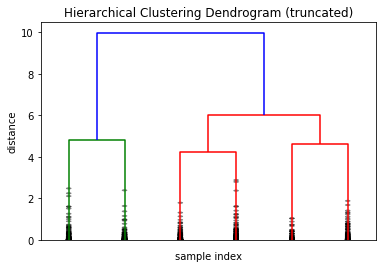

In [34]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index')
plt.ylabel('distance')
hierarchy.dendrogram(
    z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=6,  # show only the last p merged clusters
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

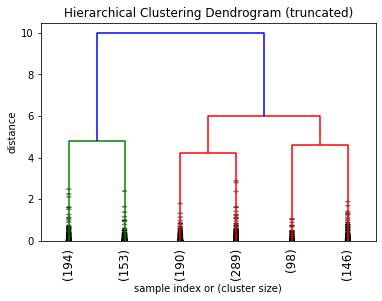

In [35]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
hierarchy.dendrogram(
    z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=6,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

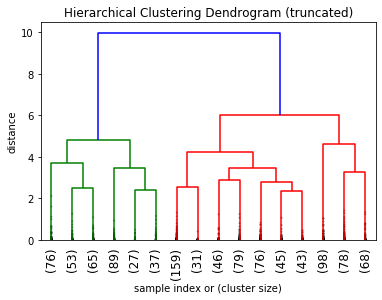

In [36]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = hierarchy.dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

fancy_dendrogram(
    z,
    truncate_mode='lastp',
    p=16,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,  # useful in small plots so annotations don't overlap
)
plt.show()

1, substract each cluster with the top 20 most popular titles
2, remove trailers and unknown ones
3, filter the titles before clustering ( remove trailers and unknown; top 80% performer;)

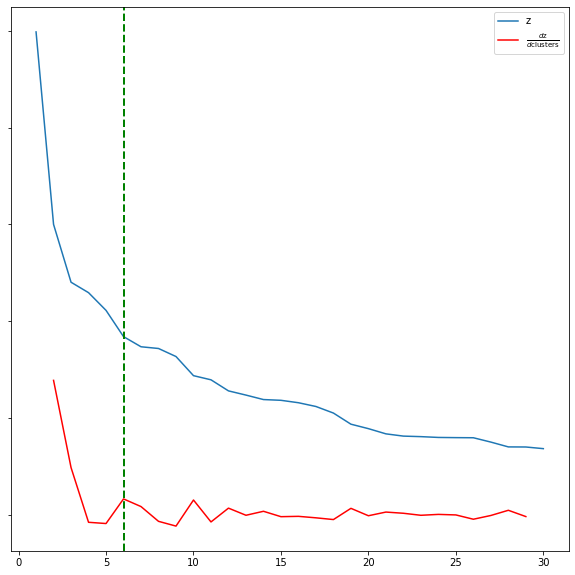

In [37]:
# Quick look at the eblow curve

last = z[-30:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

ax.plot(idxs, last_rev, label='z')
ax.plot(idxs[:-2] + 1, acceleration_rev, color='red', label=r'$\frac{d\mathrm{z}}{d\mathrm{clusters}}$')
ax.set_yticklabels([])

leg = plt.legend(loc=0)

ax.axvline(6, ls='--', color='green', lw=2)
# ax.text(16.5, 5.5, 'k=16', {'size': 15})

In [38]:
# Generating results for K number of clusters
clusters = fcluster(z, number_of_clusters, criterion='maxclust')

In [39]:
clusters

array([5, 3, 5, ..., 6, 1, 6], dtype=int32)

In [40]:
result = all_index.copy()
result['CLUSTER'] = clusters

In [41]:
result.groupby('CLUSTER').agg({'ACQUIRING_POWER':'mean','RETENTION_POWER':'mean'})

,ACQUIRING_POWER,RETENTION_POWER
CLUSTER,,
1,0.087311,0.198711
2,0.010819,0.015875
3,0.107895,0.076846
4,0.174443,0.246028
5,0.261342,0.504329
6,0.078283,0.049992


In [42]:
pd.set_option('display.max_rows', None)
result[result.CLUSTER==5].sort_values(by='ACQUIRING_POWER', ascending=False).head(100)

,INDEX_x,CONSOLIDATED_TITLE,LEVEL_1_CATG_NAME,INDEX_y,ACQUIRING_POWER,RETENTION_POWER,title,ACQUIRING_POWER_std,RETENTION_POWER_std,CLUSTER
2,2,friends,series,Friends,6.679881,20.532381,friends,0.995558,1.000000,5
31,31,sex and the city,series,Sex and the City,1.562007,2.453214,sex and the city,0.991032,0.990955,5
277,294,sex and the city,movies,Sex and the City,1.562007,2.453214,sex and the city,0.991032,0.990955,5
11,11,and just like that...,series,And Just Like That...,1.474509,0.449452,and just like that...,0.990954,0.989952,5
78,78,pretty little liars,series,Pretty Little Liars,1.094109,1.150812,pretty little liars,0.990618,0.990303,5
152,152,the nanny,series,The Nanny,0.618018,1.097230,the nanny,0.990197,0.990276,5
0,0,euphoria,series,Euphoria,0.617156,0.213307,euphoria,0.990196,0.983432,5
104,104,gossip girl (2007),series,Gossip Girl (2007),0.547738,0.873107,gossip girl (2007),0.990134,0.990164,5
103,103,in the heights,movies,In the Heights,0.324043,0.086714,in the heights,0.989937,0.972085,5
47,47,friends: the reunion,special,Friends: The Reunion,0.306683,0.039995,friends: the reunion,0.989921,0.950954,5


In [43]:
result.sort_values(by=['CLUSTER','ACQUIRING_POWER'], ascending=False).groupby('CLUSTER').head().

,INDEX_x,CONSOLIDATED_TITLE,LEVEL_1_CATG_NAME,INDEX_y,ACQUIRING_POWER,RETENTION_POWER,title,ACQUIRING_POWER_std,RETENTION_POWER_std,CLUSTER
10,10,the suicide squad,movies,The Suicide Squad,1.637846,0.807640,the suicide squad,0.991099,0.990131,6
98,98,malignant,movies,Malignant,0.968802,0.464288,malignant,0.990507,0.989960,6
79,79,the many saints of newark,movies,The Many Saints of Newark,0.930598,0.379125,the many saints of newark,0.990473,0.989917,6
138,138,cry macho,movies,Cry Macho,0.529007,0.231315,cry macho,0.990118,0.984328,6
22,22,the little things,movies,The Little Things,0.451972,0.093865,the little things,0.990050,0.973115,6
2,2,friends,series,Friends,6.679881,20.532381,friends,0.995558,1.000000,5
31,31,sex and the city,series,Sex and the City,1.562007,2.453214,sex and the city,0.991032,0.990955,5
277,294,sex and the city,movies,Sex and the City,1.562007,2.453214,sex and the city,0.991032,0.990955,5
11,11,and just like that...,series,And Just Like That...,1.474509,0.449452,and just like that...,0.990954,0.989952,5
78,78,pretty little liars,series,Pretty Little Liars,1.094109,1.150812,pretty little liars,0.990618,0.990303,5


In [57]:
result.groupby('CLUSTER').apply(lambda x : x.sort_values(by = 'ACQUIRING_POWER', ascending = False).head(10)).to_csv('top_10.csv',index=False)

In [44]:
result.dtypes

INDEX_x                  int16
CONSOLIDATED_TITLE      object
LEVEL_1_CATG_NAME       object
INDEX_y                 object
ACQUIRING_POWER        float64
RETENTION_POWER        float64
title                   object
ACQUIRING_POWER_std    float64
RETENTION_POWER_std    float64
CLUSTER                  int32
dtype: object

In [45]:
def get_movie_id(name):
    ia = imdb.IMDb()
    # searching the name 
    search = ia.search_movie(name)
    # loop for printing the name and id
    for i in range(len(search)):
        # getting the id
        id = search[i].movieID
        # printing it
        print(search[i]['title'] + " : " + id )
        return id

In [46]:
get_movie_id('the matrix: resurrections')

NameError: name 'imdb' is not defined

In [ ]:
from bs4 import BeautifulSoup

In [ ]:
import imdb
import urllib.request  as urllib2 

access = imdb.IMDb()
movie = access.get_movie('16894314')
print("Cover url: %s" % movie['full-size cover url'])
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= movie['full-size cover url'],width=300, height=300)

In [ ]:
from IPython.display import HTML, display
imgurl=movie['full-size cover url']
display(HTML(f'''<table><tr><td><img src={imgurl} width='20%'></td><td><img src={imgurl} width='20%'></td></tr></table>'''))

In [ ]:
from IPython.display import HTML, display,IFrame
import imdb
import urllib.request  as urllib2 

access = imdb.IMDb()


topmovies_df=result.drop_duplicates(subset='title').sort_values(by=['CLUSTER','ACQUIRING_POWER'], ascending=False).groupby('CLUSTER').head(5)
topmovies_df.head()
htmlstr=f'''<table>'''
n=5
for index, row in topmovies_df.iterrows():    
    if (n>0):
        if (n==5):
            htmlstr=htmlstr+'<tr>'
        try:
            movie_id=get_movie_id(row['title'])
            cluster_id=row['CLUSTER']
            movie = access.get_movie(movie_id)
            imgurl=movie['full-size cover url']
            htmlstr=htmlstr+f'''<td><img src={imgurl} width="200""></td>'''
        except:
            htmlstr=htmlstr+f'''<td>Missing</td>'''
        #print(row['title'], row['CLUSTER'])
        if (n==1):
            htmlstr=htmlstr+'</tr>'
            n=5
        else:
            n=n-1  
htmlstr=htmlstr+'</table>'

In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

In [ ]:

from IPython.display import HTML, display,IFrame
display(HTML(htmlstr))

In [ ]:
topmovies_df

In [ ]:
soup.find(attrs={"class" : "photo"})

In [ ]:
import imdb

access = imdb.IMDb()

In [ ]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'iframe'
fig = px.scatter(result,x='ACQUIRING_POWER_std', y='RETENTION_POWER_std',color='CLUSTER', hover_name='title', title="CONSOLIDATED_TITLE", width=800, height=640)
fig.update_layout(xaxis_title="ACQUIRING_POWER_std", yaxis_title="RETENTION_POWER_std")
fig.show()

In [ ]:
gamethrongcluster=result[result['CLUSTER'] == result[result['CONSOLIDATED_TITLE'] == 'game of thrones']['CLUSTER'].values[0]][['CONSOLIDATED_TITLE', 'LEVEL_1_CATG_NAME', 'CLUSTER']].rename(columns={'CONSOLIDATED_TITLE': 'title','LEVEL_1_CATG_NAME': 'title_type','CLUSTER': 'cluster_number'}).sort_values('title', ascending=True)
gamethrongcluster.head()

In [ ]:
gamethrongcluster[gamethrongcluster['title'].str.contains('sex and the city')]

In [ ]:
(
    result[result['CLUSTER'] == result[result['CONSOLIDATED_TITLE'] == 'game of thrones']['CLUSTER'].values[0]]
    [['CONSOLIDATED_TITLE', 'LEVEL_1_CATG_NAME', 'CLUSTER']]
    .rename(columns={
        'CONSOLIDATED_TITLE': 'title',
        'LEVEL_1_CATG_NAME': 'title_type',
        'CLUSTER': 'cluster_number'
    })
    .sort_values('title', ascending=True)
)

In [ ]:
gamethrone=input_master[(input_master['CONSOLIDATED_TITLE_1']=='game of thrones') & (input_master['LEVEL_1_CATG_NAME_1']!='trailer') & (input_master['LEVEL_1_CATG_NAME_2']!='trailer')].sort_values(by='SCORE',ascending=False)
gamethrone.head()

In [ ]:
gamethrone.head(30)

In [ ]:
result_map = dict(zip(result['INDEX'], result['CLUSTER']))

In [ ]:
result_map

# 4 : Cluster Assignment for rest of the shows

In [ ]:
# These outputs are generated by the audience overlap model suite

input_master_full_table = f'../Audience_Overlap/{overlap_output_date}_audience_overlap_endpoint_table_max{long_tail}.csv'
input_index_full_table = f'../Audience_Overlap/{overlap_output_date}_audience_overlap_id_mapping_table_output_max{long_tail}.csv'

input_master_full = pd.read_csv(input_master_full_table)
input_index_full = pd.read_csv(input_index_full_table)

In [ ]:
audience_overlap_all_titles = pd.pivot_table(
    input_master_full, 
    values='SCORE', 
    index=['INDEX_1'],
    columns=['INDEX_2'], 
    aggfunc=np.sum
)
audience_overlap_all_titles = audience_overlap_all_titles.reset_index()
audience_overlap_all_titles = audience_overlap_all_titles.set_index('INDEX_1')

In [ ]:
audience_overlap_all_titles.iloc[0:3, 0:3]

In [ ]:
distance_matrix_all_titles = 1 - audience_overlap_all_titles.iloc[:, :]

In [ ]:
cluster_list = result['CLUSTER'].unique()
print(f'Cluster list: {cluster_list}')

count = 0
cluster_assignment = {}
temp_dict = {}
verbose = False

for i in range(audience_overlap_all_titles.shape[0]):

    if i not in result_map:
        
        # Calculate distance to each cluster
        for cluster_number in cluster_list:
            
            cluster_members_index = result[result.CLUSTER == cluster_number]['INDEX'].tolist()
            distance = [float(distance_matrix_all_titles[i][index]) for index in cluster_members_index]
            
            # Average distance (similarity) to the cluster members
            temp_dict[cluster_number] = sum(distance) / (1.0*len(distance))
            
        cluster_assignment[i] = min(temp_dict.keys(), key=(lambda k: temp_dict[k]))
        if verbose:
            print(f'Cluster with minimum distance: {cluster_assignment[i]}')
        
        count += 1
    else:
        cluster_assignment[i] = result_map[i]
print(f'Number of titles given a cluster assignment: {count}')

In [ ]:
scoring_df = pd.DataFrame(cluster_assignment.items(), columns=['INDEX', 'CLUSTER'])
assignments = input_index_full.merge(scoring_df, on='INDEX', how='inner')
assignments = (
        assignments.rename(columns={
        'CONSOLIDATED_TITLE': 'title',
        'LEVEL_1_CATG_NAME': 'title_type',
        'CLUSTER': 'cluster_number'
    })
    [['title', 'title_type', 'cluster_number']]
)

In [ ]:
assignments[
    assignments['cluster_number'] == assignments[assignments['title'] == 'leaving neverland']['cluster_number'].values[0]
    ].head(50)

In [ ]:
pd.set_option('max_colwidth', 400)

In [ ]:
pd.DataFrame(
    assignments[['cluster_number', 'title']].groupby(['cluster_number']).apply(lambda x: ', '.join(x['title'].values[:4]))
)

In [ ]:
assignments.groupby(['cluster_number', 'title_type']).count()

In [ ]:
assignments.shape